# Проект: классификация

Данные о клиентах банка:<br/>
<br/>
age (возраст);<br/>
job (сфера занятости);<br/>
marital (семейное положение);<br/>
education (уровень образования);<br/>
default (имеется ли просроченный кредит);<br/>
housing (имеется ли кредит на жильё);<br/>
loan (имеется ли кредит на личные нужды);<br/>
balance (баланс).<br/><br/><br/>
Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:<br/><br/>

contact (тип контакта с клиентом);<br/>
month (месяц, в котором был последний контакт);<br/>
day (день, в который был последний контакт);<br/>
duration (продолжительность контакта в секундах).<br/><br/><br/>
Прочие признаки:<br/><br/>

campaign (количество контактов с этим клиентом в течение текущей кампании);<br/>
pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);<br/>
previous (количество контактов до текущей кампании)<br/>
poutcome (результат прошлой маркетинговой кампании).<br/>
И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import optuna


## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [3]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,"1,00 $",yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,"733,00 $",no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,"29,00 $",no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0 $,no,yes,cellular,8,may,9,2,172,5,failure,no


In [4]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [5]:
df.isnull().sum().sort_values(ascending=False)

balance      25
age           0
day           0
poutcome      0
previous      0
pdays         0
campaign      0
duration      0
month         0
contact       0
job           0
loan          0
housing       0
default       0
education     0
marital       0
deposit       0
dtype: int64

Пропуски в признаке balance (25 пропусов)

### Задание 2

In [6]:
# есть ли в данных пропущенные значения? Возможно, они обозначены каким-то специальным словом?
object_colums = [s for s in df.columns if df[s].dtypes=='object']
object_colums
unique_val = {}

for col in object_colums:
    unique_val[col] = list(df[col].unique())

unique_val

{'job': ['admin.',
  'technician',
  'services',
  'management',
  'retired',
  'blue-collar',
  'unemployed',
  'entrepreneur',
  'housemaid',
  'unknown',
  'self-employed',
  'student'],
 'marital': ['married', 'single', 'divorced'],
 'education': ['secondary', 'tertiary', 'primary', 'unknown'],
 'default': ['no', 'yes'],
 'balance': [' 2 343,00 $ ',
  ' 45,00 $ ',
  ' 1 270,00 $ ',
  ' 2 476,00 $ ',
  ' 184,00 $ ',
  '0  $ ',
  ' 830,00 $ ',
  ' 545,00 $ ',
  ' 1,00 $ ',
  nan,
  ' 100,00 $ ',
  ' 309,00 $ ',
  ' 199,00 $ ',
  ' 460,00 $ ',
  ' 703,00 $ ',
  ' 3 837,00 $ ',
  ' 611,00 $ ',
  '-8,00 $ ',
  ' 55,00 $ ',
  ' 168,00 $ ',
  ' 785,00 $ ',
  ' 2 067,00 $ ',
  ' 388,00 $ ',
  '-192,00 $ ',
  ' 381,00 $ ',
  ' 40,00 $ ',
  ' 22,00 $ ',
  ' 3,00 $ ',
  ' 307,00 $ ',
  ' 759,00 $ ',
  '-1,00 $ ',
  ' 65,00 $ ',
  ' 82,00 $ ',
  ' 10,00 $ ',
  ' 390,00 $ ',
  ' 311,00 $ ',
  ' 414,00 $ ',
  ' 5,00 $ ',
  ' 119,00 $ ',
  ' 4,00 $ ',
  ' 1 262,00 $ ',
  ' 1 949,00 $ ',
  '-395,0

Видим, что в данных встречаются пропуски под словом "unknown". Так же признак balance нужно преобразовть в число.

### Задание 3

In [7]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df["balance"] = df["balance"].str.replace('$','')
df["balance"] = df["balance"].str.replace(' ','')
df["balance"] = df["balance"].str.replace(',','.')
df["balance"] = df["balance"].astype(float)
df["balance"]

0        2343.0
1          45.0
2        1270.0
3        2476.0
4         184.0
          ...  
11157       1.0
11158     733.0
11159      29.0
11160       0.0
11161       0.0
Name: balance, Length: 11162, dtype: float64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11162 non-null  int64  
 1   job        11162 non-null  object 
 2   marital    11162 non-null  object 
 3   education  11162 non-null  object 
 4   default    11162 non-null  object 
 5   balance    11137 non-null  float64
 6   housing    11162 non-null  object 
 7   loan       11162 non-null  object 
 8   contact    11162 non-null  object 
 9   day        11162 non-null  int64  
 10  month      11162 non-null  object 
 11  duration   11162 non-null  int64  
 12  campaign   11162 non-null  int64  
 13  pdays      11162 non-null  int64  
 14  previous   11162 non-null  int64  
 15  poutcome   11162 non-null  object 
 16  deposit    11162 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


### Задание 4

In [9]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
mean_balance = df['balance'].mean()
print(f'Среднее значение по признаку balance равно ', round(mean_balance, 3))

median_balance = df['balance'].median()
print(f'Медиана по признаку balance равна ', round(median_balance, 3))

Среднее значение по признаку balance равно  1529.129
Медиана по признаку balance равна  550.0


In [10]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'].describe()

count    11137.000000
mean      1529.129029
std       3228.114892
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1708.000000
max      81204.000000
Name: balance, dtype: float64

In [11]:
# т.к. в признаке balance встречаются выбросы( максимальное число = 81204, когда 75-ый процентиль равен 1708), возьмем для пропусков медиану
df['balance'].fillna(median_balance, inplace =True)

In [12]:
mean_balance = df['balance'].mean()
print(f'Среднее значение по признаку balance теперь равно ', round(mean_balance, 3))


Среднее значение по признаку balance теперь равно  1526.936


### Задание 5

In [13]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
mode_job = df['job'].mode()[0]
mode_education = df['education'].mode()[0]

df['job'] = df['job'].str.replace('unknown',mode_job)
df['education'] = df['education'].str.replace('unknown',mode_education )

In [14]:
df['job'].value_counts()

management       2636
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
Name: job, dtype: int64

После замены пропусков рассчитайте средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование). Ответ округлите до трёх знаков после точки-разделителя.

In [15]:
popular_job = df['job'].value_counts().index[0]
popular_education = df['education'].value_counts().index[0]

mean_balnce_for_sample = df[(df['job']==popular_job) & (df['education']==popular_education)]['balance'].mean()
print(round(mean_balnce_for_sample, 3))

1598.883


### Задание 6

In [16]:
# удалите все выбросы для признака balance
# найдем выбросы методом Тьюки

Q1 = df['balance'].quantile(0.25)
Q3 = df['balance'].quantile(0.75)
IQE = Q3 - Q1
min_limit = Q1 - 1.5*IQE
max_limit = Q3 + 1.5*IQE
print('Нижняя граница', round(min_limit))
print('Верхняя граница', round(max_limit))
# ваш код

Нижняя граница -2241
Верхняя граница 4063


In [17]:
#удалим выбросы
outliers = df[(df['balance'] < min_limit) | (df['balance']>max_limit)]
df = df.drop(outliers.index, axis=0)
print(f'Результирующее число записей: {df.shape[0]}')

Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

In [18]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
df['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

<AxesSubplot:xlabel='deposit', ylabel='count'>

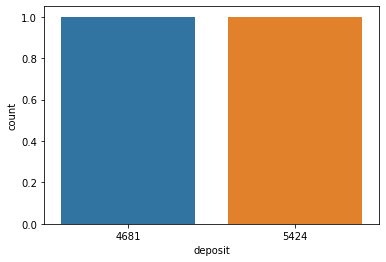

In [19]:
sns.countplot(df['deposit'].value_counts())

Данные сбалансированы

### Задание 2

In [20]:
dict_to_rus = {
    'age':'возраст',
    'job':'сфера занятости',
    'marital':'семейное положение',
    'education':'уровень образования',
    'default':'имеется ли просроченный кредит',
    'balance':'баланс',
    'housing':'имеется ли кредит на жильё',
    'loan':'имеется ли кредит на личные нужды',
    'contact':'тип контакта с клиентом',
    'day':'день, в который был последний контакт',
    'month':'месяц, в котором был последний контакт',
    'duration':'продолжительность контакта в секундах',
    'campaign':'количество контактов с этим клиентом в течение текущей кампании',
    'pdays':'количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании',
    'previous':'количество контактов до текущей кампании',
    'poutcome':'результат прошлой маркетинговой кампании',
    'deposit':'согласен ли на депозит'
}

In [21]:
pd.DataFrame(list(dict_to_rus.values()), index = list(dict_to_rus.keys()), columns = ['Расшифровка'])

,Расшифровка
age,возраст
job,сфера занятости
marital,семейное положение
education,уровень образования
default,имеется ли просроченный кредит
balance,баланс
housing,имеется ли кредит на жильё
loan,имеется ли кредит на личные нужды
contact,тип контакта с клиентом
day,"день, в который был последний контакт"


In [22]:
pd.concat([pd.DataFrame(list(dict_to_rus.values()), index = list(dict_to_rus.keys()), columns = ['расшифровка']), 
           df.describe().T], join='inner',  axis = 1, sort = False)

,расшифровка,count,mean,std,min,25%,50%,75%,max
age,возраст,10105.0,40.895497,11.734931,18.0,32.0,38.0,48.0,95.0
balance,баланс,10105.0,807.653538,994.151966,-2049.0,95.0,445.0,1227.0,4063.0
day,"день, в который был последний контакт",10105.0,15.590302,8.441510,1.0,8.0,15.0,22.0,31.0
duration,продолжительность контакта в секундах,10105.0,368.742603,346.651524,2.0,137.0,252.0,490.0,3881.0
campaign,количество контактов с этим клиентом в течение...,10105.0,2.517170,2.707159,1.0,1.0,2.0,3.0,43.0
pdays,количество пропущенных дней с момента последне...,10105.0,51.319644,109.644179,-1.0,-1.0,-1.0,2.0,854.0
previous,количество контактов до текущей кампании,10105.0,0.816230,2.243795,0.0,0.0,0.0,1.0,58.0


In [23]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задание 3

In [24]:
object_colums = [s for s in df.columns if df[s].dtypes=='object']
numeric_colums = [s for s in df.columns if df[s].dtypes!='object']

In [25]:
pd.concat([pd.DataFrame(list(dict_to_rus.values()), index = list(dict_to_rus.keys()), columns = ['расшифровка']), 
           df[object_colums].describe().T], join='inner',  axis = 1, sort = False)

,расшифровка,count,unique,top,freq
job,сфера занятости,10105,11,management,2315
marital,семейное положение,10105,3,married,5715
education,уровень образования,10105,3,secondary,5517
default,имеется ли просроченный кредит,10105,2,no,9939
housing,имеется ли кредит на жильё,10105,2,no,5243
loan,имеется ли кредит на личные нужды,10105,2,no,8712
contact,тип контакта с клиентом,10105,3,cellular,7283
month,"месяц, в котором был последний контакт",10105,12,may,2617
poutcome,результат прошлой маркетинговой кампании,10105,4,unknown,7570
deposit,согласен ли на депозит,10105,2,no,5424


In [26]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
df[object_colums].describe()

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


#### Столбчатые диаграммы для категориальных признаков в разрезе целевой переменной

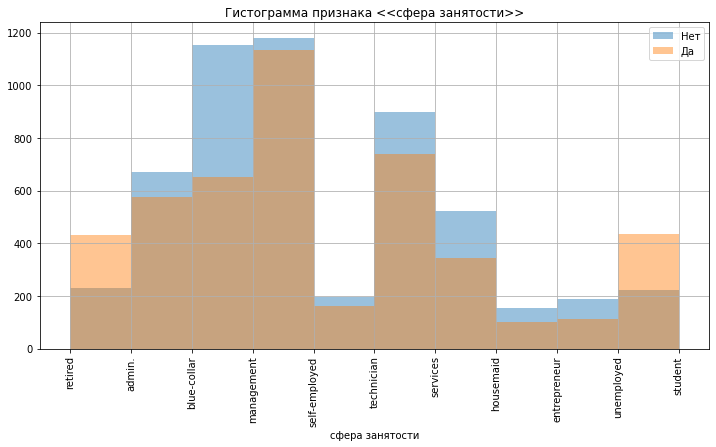

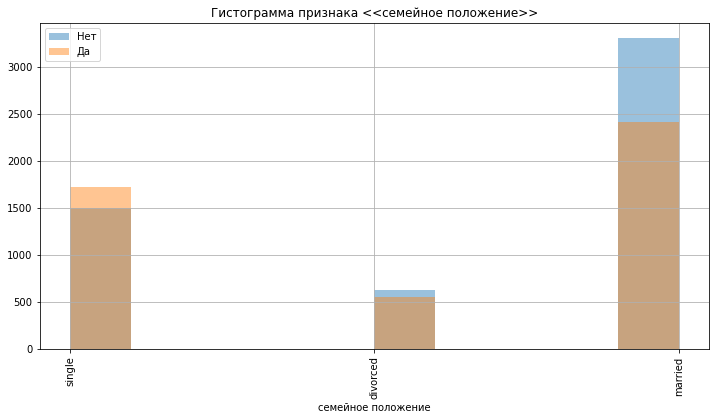

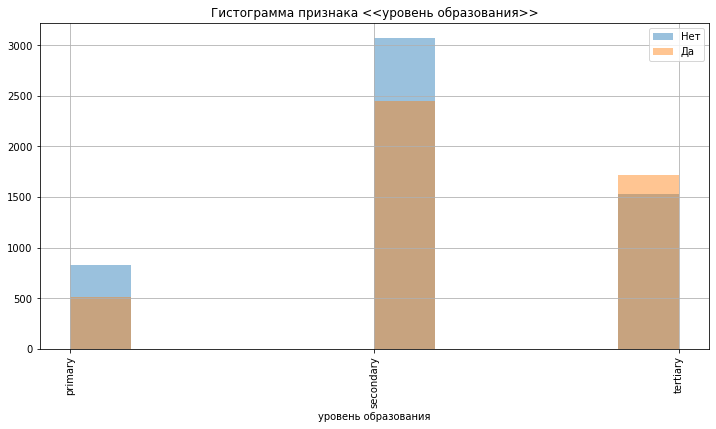

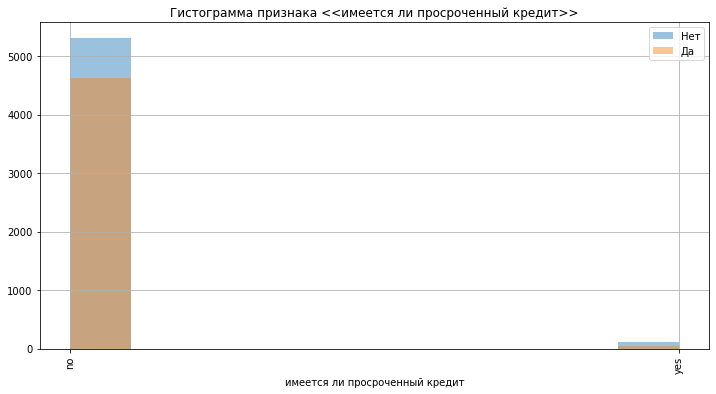

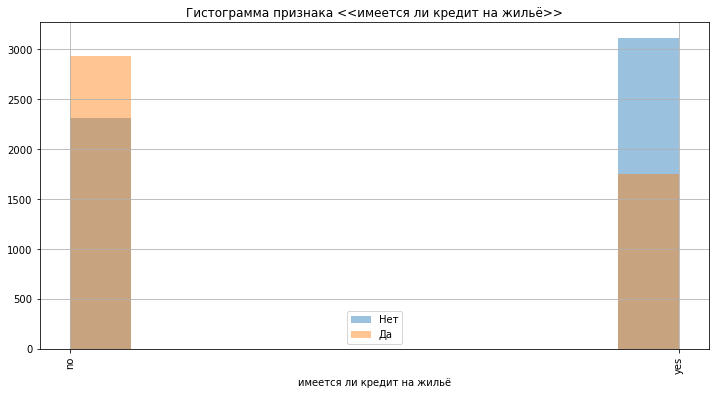

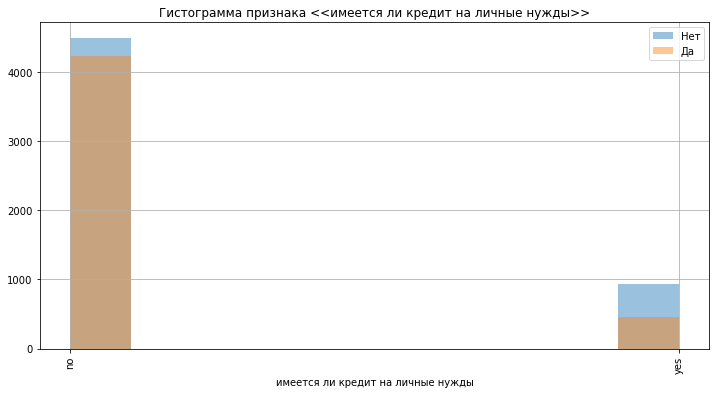

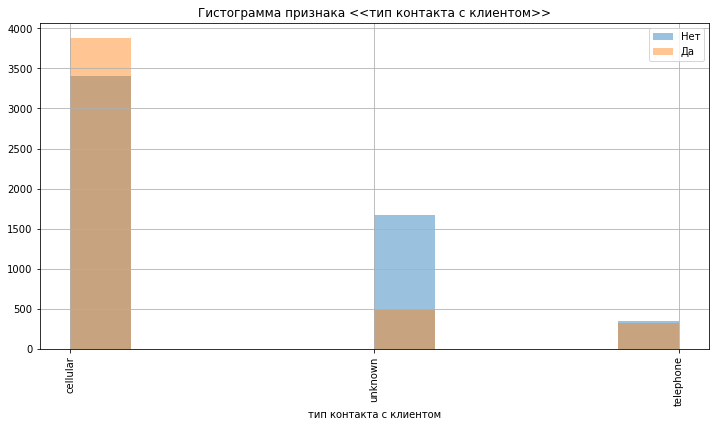

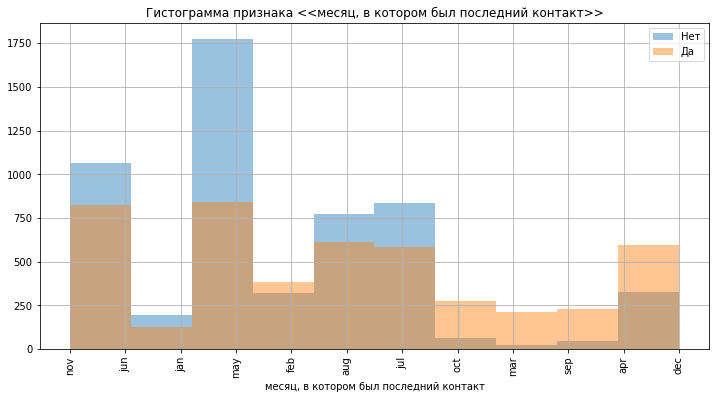

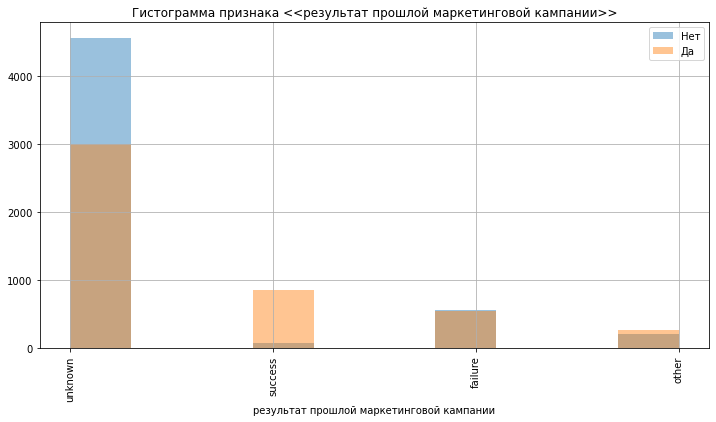

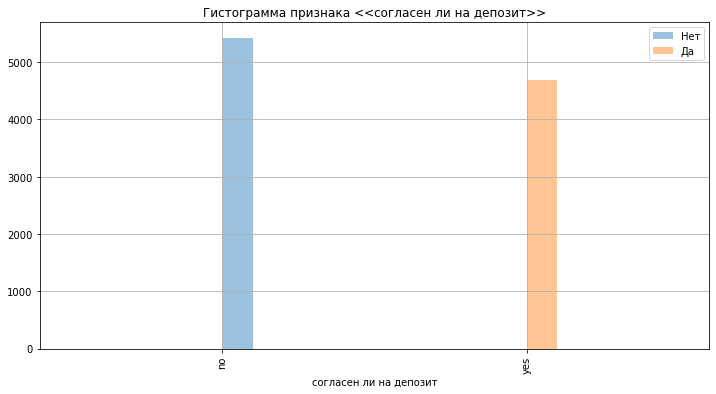

In [27]:
for col in object_colums:
    plt.figure(figsize=(12,6))
    df.groupby('deposit')[col].hist(alpha = 0.45)
    plt.title("Гистограмма признака <<{}>>".format(dict_to_rus[col]))
    plt.xlabel(dict_to_rus[col])
    plt.legend(['Нет', 'Да'])
    plt.xticks(rotation=90)
    plt.show()

**Промежуточный вывод:**
1) Больше соглашаются на депозит те, кто в отставке и студенты. Больше всего отказов среди рабочих
2) Те, кто состоят в семейном положении чаще отказывают. Холостые же чаще соглашаются.
3) Людт с высшим образованием чаще соглашаются
4) Среди тех, у кого есть кредит на жилье, больше отказов. У кого нет кредита - больше согласных
5) Большинство тех, с кем связывались по мотовому телефону, согласились

Рассмотрим подробнее гистограмму по месяцу, в котором был последний контакт

Сколько было месяцев, в которых проводилась маркетинговая кампания?


Заменим название месяца на его номер:

In [28]:
'''month = {
    'jan':1,
    'feb':2,
    'mar':3,
    'apr':4,
    'may':5,
    'jun':6,
    'jul':7,
    'aug':8,
    'sep':9,
    'oct':10,
    'nov':11,
    'dec':12
}'''

"month = {\n    'jan':1,\n    'feb':2,\n    'mar':3,\n    'apr':4,\n    'may':5,\n    'jun':6,\n    'jul':7,\n    'aug':8,\n    'sep':9,\n    'oct':10,\n    'nov':11,\n    'dec':12\n}"

In [29]:
#df['month'] = df['month'].apply(lambda x: month[x])
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no


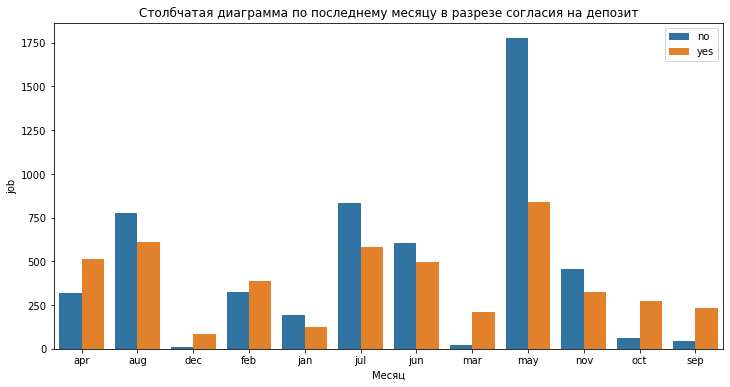

In [30]:
df_month = df.groupby(['month','deposit'], as_index=False)['job'].count()
#sns.histplot(x = df_month['month'], )

plt.figure(figsize=(12,6))
sns.barplot(data=df_month, x='month', y = 'job', hue='deposit')
plt.title("Столбчатая диаграмма по последнему месяцу в разрезе согласия на депозит")
plt.xlabel('Месяц')
plt.legend()
plt.show()

**Промежуточный итог:**

Чаще всего отказывают в депозите в мае (соглашаются в два раза реже, чем отказываются)

### Задание 4

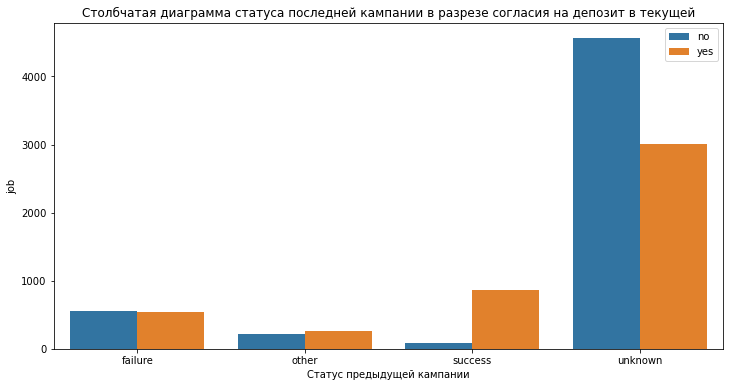

In [31]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
df_poutcome = df.groupby(['poutcome', 'deposit'])['job'].count().reset_index()


plt.figure(figsize=(12,6))
sns.barplot(data=df_poutcome, x='poutcome', y = 'job', hue='deposit')
plt.title("Столбчатая диаграмма статуса последней кампании в разрезе согласия на депозит в текущей")
plt.xlabel('Статус предыдущей кампании')
plt.legend()
plt.show()

**Промежуточный вывод:**
Среди тех, для кого предыдущая кампания закончилась успехом, количество согласившихся на депозит значительно преобдадает над отказавшимися.

### Задание 5

In [32]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
#см. выше

### Задание 6

In [33]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def get_age_group(age):
    if age<30:
        return '<30'
    elif age in range(30,40):
        return '30-40'
    elif age in range(40,50):
        return '40-50'
    elif age in range(50,60):
        return '50-60'
    else:
        return '60+'


df['age_group'] = df['age'].apply(get_age_group)

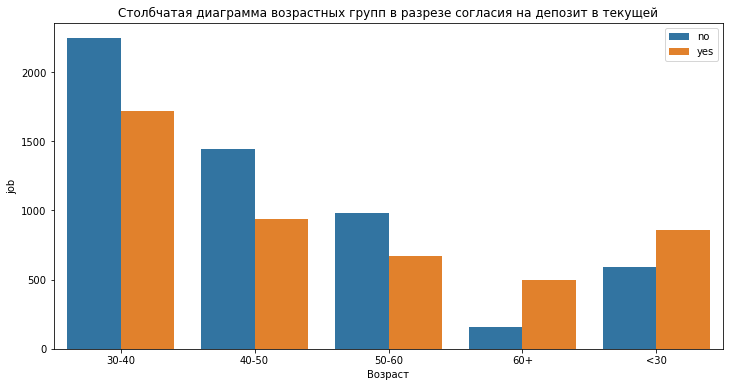

In [34]:
df_age = df.groupby(['age_group', 'deposit'])['job'].count().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=df_age, x='age_group', y = 'job', hue='deposit')
plt.title("Столбчатая диаграмма возрастных групп в разрезе согласия на депозит в текущей")
plt.xlabel('Возраст')
plt.legend()
plt.show()

**Промежуточный вывод:**

В группах 60+ и <30 преимужественно сограшаются на открытие депозита.

### Задание 7

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
 17  age_group  10105 non-null  object 
dtypes: float64(1), int64(6), object(11)
memory usage: 1.5+ MB


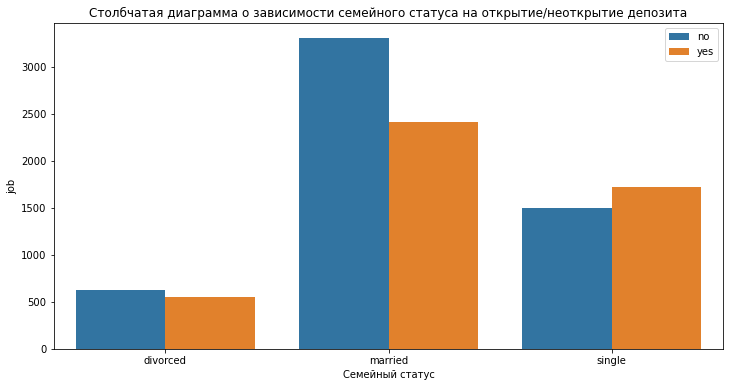

In [36]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
df_marital = df.groupby(['marital', 'deposit'])['job'].count().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=df_marital, x='marital', y = 'job', hue='deposit')
plt.title("Столбчатая диаграмма о зависимости семейного статуса на открытие/неоткрытие депозита")
plt.xlabel('Семейный статус')
plt.legend()
plt.show()

**Промежуточный вывод:**

Чаще сограшаются, чем отказываются на депозит холостые люди. Те, кто в разводе или женаты/замужем в большинстве отказываются.

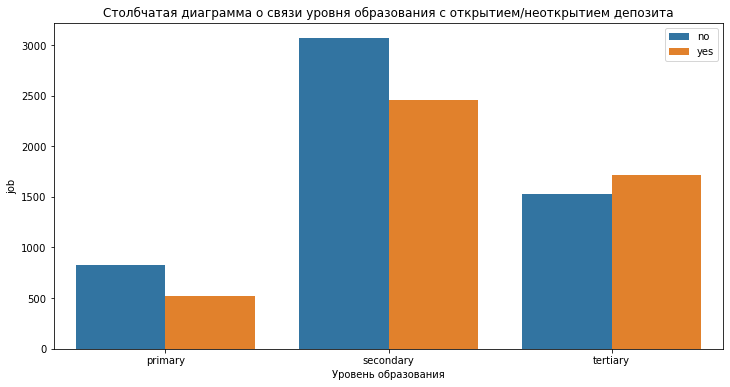

In [37]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
df_education = df.groupby(['education', 'deposit'])['job'].count().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=df_education, x='education', y = 'job', hue='deposit')
plt.title("Столбчатая диаграмма о связи уровня образования с открытием/неоткрытием депозита")
plt.xlabel('Уровень образования')
plt.legend()
plt.show()

**Промежуточный вывод:**

Люди с высшим образованием чаще соглашаются на открытие депозита, чем с начальным или среднем образованием.

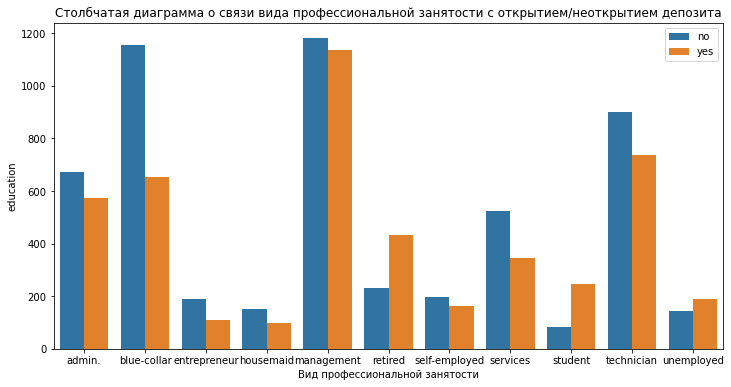

In [38]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
df_job = df.groupby(['job', 'deposit'])['education'].count().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=df_job, x='job', y = 'education', hue='deposit')
plt.title("Столбчатая диаграмма о связи вида профессиональной занятости с открытием/неоткрытием депозита")
plt.xlabel('Вид профессиональной занятости')
plt.legend()
plt.show()

**Промежуточный вывод:**

Больше соглашаются на депозит те, кто находится в отставке, студенты и безработные. Больше всего отказов среди рабочих.

### Задание 8

Text(767.7272727272725, 0.5, 'Уровень образования')

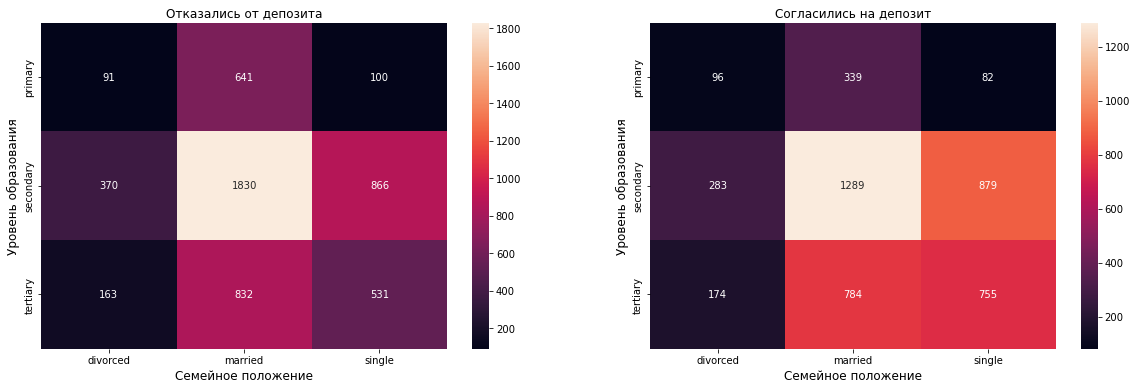

In [39]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

df_no = df[df.deposit == 'no'][['education', 'marital', 'age']]
df_yes = df[df.deposit == 'yes'][['education', 'marital', 'age']]

pivot_no = pd.pivot_table(data=df_no, index = 'education', columns='marital', values = 'age', aggfunc='count')
pivot_yes = pd.pivot_table(data=df_yes, index = 'education', columns='marital', values = 'age', aggfunc='count')

plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
sns.heatmap(pivot_no, annot=True, fmt='.5g')
plt.title('Отказались от депозита')
plt.xlabel('Семейное положение', fontsize = 12)
plt.ylabel('Уровень образования', fontsize = 12)

plt.subplot(1,2,2)
sns.heatmap(pivot_yes, annot=True, fmt='.5g')
plt.title('Согласились на депозит')
plt.xlabel('Семейное положение', fontsize = 12)
plt.ylabel('Уровень образования', fontsize = 12)

## Часть 3: преобразование данных

### Задание 1

In [40]:
# преобразуйте уровни образования
LE=LabelEncoder()
df['education'] = LE.fit_transform(df['education'])

df['education'].sum()

11995

In [41]:
df['age_group'] = LE.fit_transform(df['age_group'])
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,2
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,2
2,41,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,1
3,55,services,married,1,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,2
4,54,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,0,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no,0
11158,39,services,married,1,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no,0
11159,32,technician,single,1,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no,0
11160,43,technician,married,1,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no,1


### Задание 2

In [42]:
# преобразуйте бинарные переменные в представление из нулей и единиц
bin_columns = ['deposit','default','housing','loan']

for col in bin_columns:
    df[col] = df[col].apply(lambda x: 1 if x=='yes' else 0)

df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,2
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,2
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,1
3,55,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,2
4,54,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,0,0,1.0,1,0,cellular,20,apr,257,1,-1,0,unknown,0,0
11158,39,services,married,1,0,733.0,0,0,unknown,16,jun,83,4,-1,0,unknown,0,0
11159,32,technician,single,1,0,29.0,0,0,cellular,19,aug,156,2,-1,0,unknown,0,0
11160,43,technician,married,1,0,0.0,0,1,cellular,8,may,9,2,172,5,failure,0,1


### Задание 3

In [43]:
# создайте дамми-переменные
df = pd.get_dummies(df)
print(len(list(df.columns)))

46


### Задание 4

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
age,1.000000,-0.191124,-0.009929,0.115164,-0.164196,-0.026357,0.000396,-0.006007,-0.001143,0.006107,...,0.009769,0.024785,-0.119656,0.026875,0.056998,0.036352,0.001994,-0.020942,0.060009,-0.031455
education,-0.191124,1.000000,-0.015692,0.043251,-0.094350,-0.052566,0.008989,-0.016869,-0.012280,0.024123,...,-0.036503,0.052196,-0.104157,0.028704,0.027617,0.030846,0.019845,0.015103,0.070489,-0.069069
default,-0.009929,-0.015692,1.000000,-0.110928,0.009551,0.074786,0.018724,-0.008162,0.033404,-0.037323,...,0.019626,-0.020028,-0.001761,0.000544,-0.023931,-0.016977,-0.025450,-0.017923,-0.041510,0.055032
balance,0.115164,0.043251,-0.110928,1.000000,-0.094919,-0.113089,-0.009987,0.025781,-0.042689,0.045155,...,0.039753,0.043832,-0.098073,0.081861,0.057041,0.047841,0.031040,0.028111,0.073358,-0.085456
housing,-0.164196,-0.094350,0.009551,-0.094919,1.000000,0.072252,-0.022644,0.038492,0.006257,0.064138,...,-0.073133,-0.075948,0.432605,-0.000219,-0.092026,-0.086893,0.085167,0.009830,-0.134477,0.024082
loan,-0.026357,-0.052566,0.074786,-0.113089,0.072252,1.000000,0.019136,0.001476,0.033889,-0.030788,...,-0.014897,-0.041105,0.002778,0.017720,-0.032357,-0.046196,0.007458,-0.019289,-0.082098,0.059235
day,0.000396,0.008989,0.018724,-0.009987,-0.022644,0.019136,1.000000,-0.016695,0.142169,-0.078757,...,-0.182032,-0.044303,-0.014580,0.056471,0.072179,-0.068744,-0.071175,-0.008806,-0.044366,0.085442
duration,-0.006007,-0.016869,-0.008162,0.025781,0.038492,0.001476,-0.016695,1.000000,-0.042576,-0.033053,...,-0.003061,-0.034640,0.007983,-0.015655,-0.012541,-0.012077,-0.039476,-0.009497,-0.025971,0.050571
campaign,-0.001143,-0.012280,0.033404,-0.042689,0.006257,0.033889,0.142169,-0.042576,1.000000,-0.105214,...,0.046763,-0.030574,-0.044348,-0.077307,-0.071519,-0.048672,-0.082282,-0.024854,-0.094260,0.134842
pdays,0.006107,0.024123,-0.037323,0.045155,0.064138,-0.030788,-0.078757,-0.033053,-0.105214,1.000000,...,-0.093551,0.024192,0.028678,-0.007350,0.079833,0.110907,0.608719,0.338049,0.326215,-0.824031


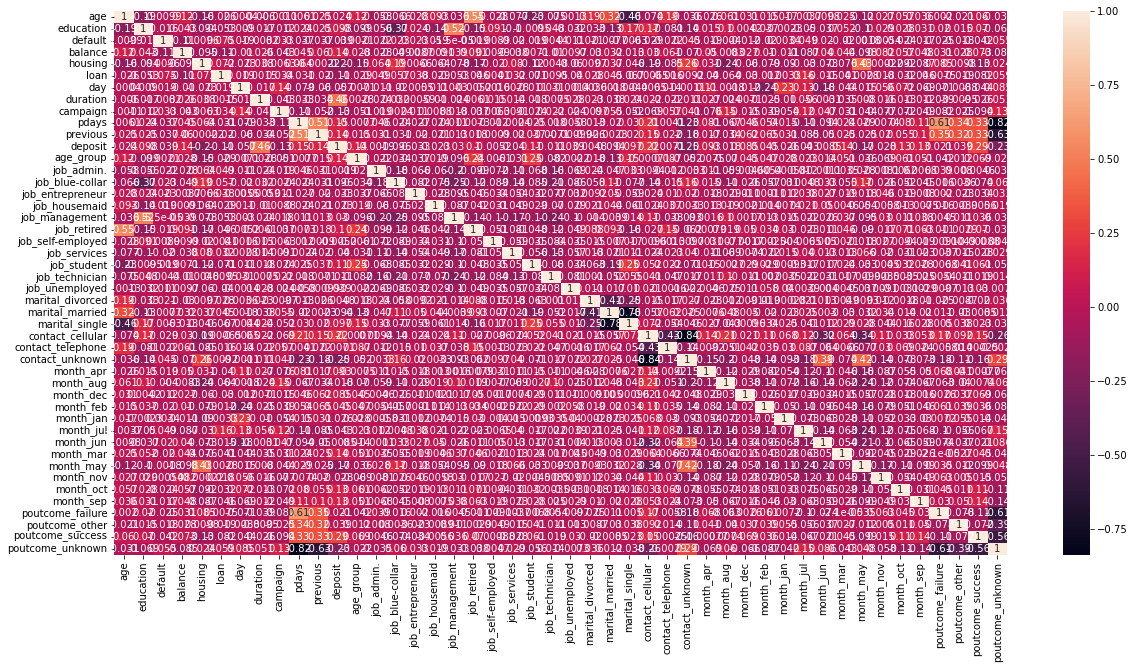

In [44]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), annot=True)
df.corr()

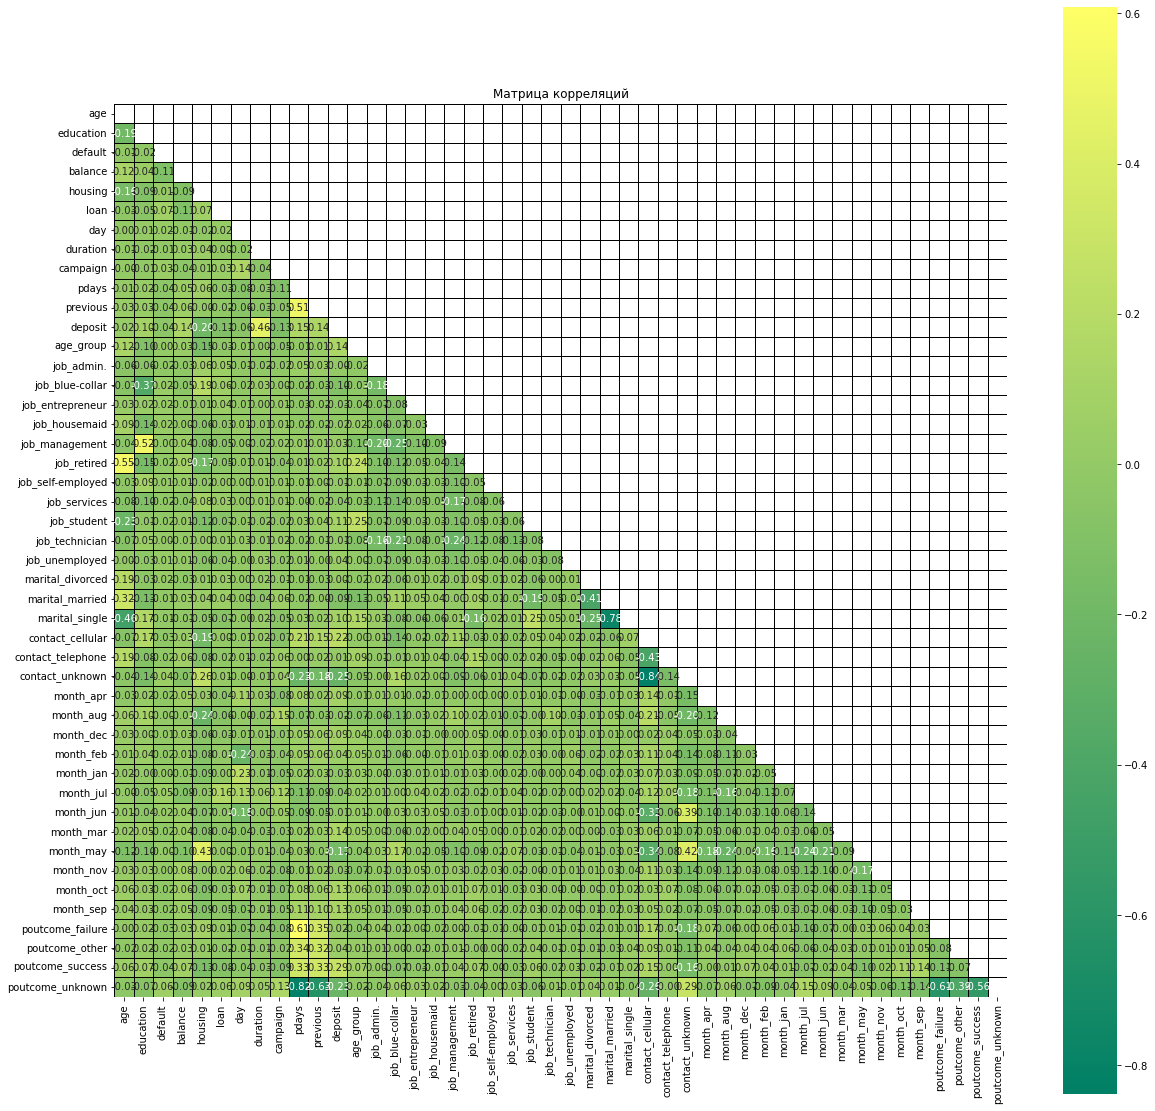

In [45]:
fig, ax = plt.subplots(figsize=(20,20))
ax = sns.heatmap(data = df.corr(), annot=True, square=True, 
            cmap='summer', fmt='.2f', linewidths=1, linecolor='black', mask=np.triu(df.corr()))
plt.title('Матрица корреляций')
plt.show()

In [46]:
correl = {}
for col in df.columns:
    cor_ind = df['deposit'].corr(df[col])
    correl[cor_ind] = col

correl = sorted(correl.items(), key=lambda x: x[0], reverse=True)
correl

[(1.0, 'deposit'),
 (0.4578176936030103, 'duration'),
 (0.28849097541165547, 'poutcome_success'),
 (0.22394444543237169, 'contact_cellular'),
 (0.14791690905586646, 'pdays'),
 (0.14110173756602162, 'previous'),
 (0.13624295274819154, 'age_group'),
 (0.13589279958349734, 'balance'),
 (0.13534838539959418, 'month_mar'),
 (0.13059949488409447, 'month_oct'),
 (0.12523904851347656, 'month_sep'),
 (0.10556256697554102, 'job_student'),
 (0.10009035232794374, 'job_retired'),
 (0.09825260709196924, 'education'),
 (0.09700512012522072, 'marital_single'),
 (0.09288849731065332, 'month_apr'),
 (0.085041478913871, 'month_dec'),
 (0.04472764453183795, 'month_feb'),
 (0.03931869994415369, 'poutcome_other'),
 (0.039195518947525994, 'job_unemployed'),
 (0.02956630069872121, 'job_management'),
 (0.02435722165005326, 'age'),
 (0.021124469058976927, 'poutcome_failure'),
 (0.007064150547954791, 'contact_telephone'),
 (0.004807619117725613, 'marital_divorced'),
 (-0.0019267704513985075, 'job_admin.'),
 (-0.

### Задание 5

In [47]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [48]:
round(y_test.mean(), 2)

0.46

### Задание 6

In [49]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
best_feature = pd.DataFrame(selector.get_feature_names_out(), columns=['name_eng'])
best_feature['name_rus'] = best_feature['name_eng'].apply(lambda x: dict_to_rus[x] if x in dict_to_rus else 0)
best_feature

,name_eng,name_rus
0,balance,баланс
1,housing,имеется ли кредит на жильё
2,duration,продолжительность контакта в секундах
3,campaign,количество контактов с этим клиентом в течение...
4,pdays,количество пропущенных дней с момента последне...
5,previous,количество контактов до текущей кампании
6,age_group,0
7,contact_cellular,0
8,contact_unknown,0
9,month_mar,0


In [50]:
best_feature_list = list(best_feature['name_eng'])

X_train = X_train[best_feature_list]
X_test = X_test[best_feature_list]


### Задание 7

In [51]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [52]:
round(X_train_scaled[0].mean(), 2)

0.24

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [53]:
# обучите логистическую регрессию и рассчитайте метрики качества

#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
#Обучаем модель, минизируя logloss
log_reg.fit(X_train_scaled, y_train)

#Делаем предсказание класса
y_pred_train = log_reg.predict(X_train_scaled)
y_pred_test = log_reg.predict(X_test_scaled)

print(round(metrics.f1_score(y_train, y_pred_train),2))
print(round(metrics.f1_score(y_test, y_pred_test),2))

0.8
0.78


In [54]:
print(round(metrics.accuracy_score(y_test, y_pred_test),2))

0.8


### Задание 2

In [55]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=6,
    random_state=42
)
#Обучаем дерево по алгоритму CART
dt.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Train: 0.82
Test: 0.81


### Задание 3

In [56]:
# подберите оптимальные параметры с помощью gridsearch
param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7]
              }
            
random_search_forest = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42, criterion='entropy'), 
    param_grid=param_grid, 
    cv=5,
    n_jobs = -1
)  
%time random_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = random_search_forest.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test_scaled, y_test)))
y_test_pred = random_search_forest.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 266 ms
Wall time: 10.9 s
f1_score на обучающем наборе: 0.82
accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.81
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [63]:
# обучите на ваших данных случайный лес
#Создаем объект класса случайный лес
rf_clf_2d = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
)
#Обучаем модель 
rf_clf_2d.fit(X_train_scaled, y_train)

#Делаем предсказание класса
y_pred_train = rf_clf_2d.predict(X_train_scaled)
y_pred_test = rf_clf_2d.predict(X_test_scaled)
#Выводим отчет о метриках
print(metrics.classification_report(y_train, y_pred_train))
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3634
           1       0.84      0.86      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 2

In [75]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = GradientBoostingClassifier(
	learning_rate = 0.05,
	n_estimators = 300,
	min_samples_leaf = 5,
	max_depth = 5,
	random_state = 42
)
gb.fit(X_train_scaled, y_train)
 
gb_pred_train  = gb.predict(X_train_scaled)
gb_pred  = gb.predict(X_test_scaled)
#print(f'Качество предсказания по f1 для GradientBoostingClassifier {round(metrics.mean_squared_error(y_test, gb_pred),2)}')
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, gb_pred)))

f1_score на тестовом наборе: 0.82


### Задание3

In [78]:
# объедините уже известные вам алгоритмы с помощью стекинга 
from sklearn.ensemble import StackingClassifier

estimators = [
    ('dt', tree.DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)),
    ('gb', GradientBoostingClassifier(learning_rate = 0.05,	n_estimators = 300,	min_samples_leaf = 5, max_depth = 5, random_state = 42))
]

reg = StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
)

reg.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=6,
                                                       random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      random_state=42,
                                                      solver='sag'))

In [79]:
y_pred_stack = reg.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred_stack))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1790
           1       0.80      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 4

In [60]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задание 5

In [ ]:
rf_clf_2d = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
)

In [86]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1),
    max_depth = trial.suggest_int('max_depth', 10, 30, 1),
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # создаем модель
    model = ensemble.RandomForestClassifier(
        n_estimators = n_estimators,
        criterion = 'gini',
        min_samples_leaf = min_samples_leaf,
        max_depth = max_depth,
        random_state = 42
    )
  # обучаем модель
    model.fit(X_train_scaled, y_train)
    score = metrics.f1_score(y_train, model.predict(X_test_scaled))
    #accuracy = metrics.accuracy_score(y_train, model.predict(X_test_scaled))

    return score

In [102]:
random_state = 42

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_test, model.predict(X_test_scaled))
  accuracy = metrics.accuracy_score(y_test, model.predict(X_test_scaled))

  return accuracy

In [103]:
%%time
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")

study.optimize(optuna_rf, n_trials=20)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

[I 2022-09-25 20:24:37,968] A new study created in memory with name: RandomForestClassifier
[I 2022-09-25 20:24:39,428] Trial 0 finished with value: 0.8257871064467767 and parameters: {'n_estimators': 182, 'max_depth': 22, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8257871064467767.
[I 2022-09-25 20:24:40,295] Trial 1 finished with value: 0.8254872563718141 and parameters: {'n_estimators': 141, 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8257871064467767.
[I 2022-09-25 20:24:41,279] Trial 2 finished with value: 0.8254872563718141 and parameters: {'n_estimators': 134, 'max_depth': 18, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8257871064467767.
[I 2022-09-25 20:24:41,927] Trial 3 finished with value: 0.8239880059970015 and parameters: {'n_estimators': 107, 'max_depth': 21, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8257871064467767.
[I 2022-09-25 20:24:42,847] Trial 4 finished with value: 0.8260869565217391 and parameters: {'n_

Наилучшие значения гиперпараметров {'n_estimators': 193, 'max_depth': 15, 'min_samples_leaf': 5}
f1_score на обучающем наборе: 0.83
CPU times: total: 21.5 s
Wall time: 24 s
